In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [8]:
%pwd
%cd C:/Users/USER/Desktop/python/competition

C:\Users\USER\Desktop\python\competition


In [17]:
actions = ['volume_up', 'volume_down', '10s_back', '10s_forword', 'stop']
path = 'C:/Users/USER/Desktop/python/competition/'
data = np.concatenate([
    np.load('dataset/seq_volume_up_1673970183.npy', allow_pickle=True),
    np.load('dataset/seq_volume_down_1673970183.npy', allow_pickle=True),
    np.load('dataset/seq_10s_back_1673970183.npy', allow_pickle=True),
    np.load('dataset/seq_10s_forword_1673970183.npy', allow_pickle=True),
    np.load('dataset/seq_stop_1673970183.npy', allow_pickle=True)
], axis=0)

data.shape

(610, 30, 58)

In [23]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(610, 30, 57)
(610,)


In [24]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(610, 5)

In [26]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=42)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(549, 30, 57) (549, 5)
(61, 30, 57) (61, 5)


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                31232     
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                                 
Total params: 33,477
Trainable params: 33,477
Non-trainable params: 0
_________________________________________________________________


In [35]:
from huggingface_hub import from_pretrained_keras

model = from_pretrained_keras("pablorodriper/video-vision-transformer")


config.json not found in HuggingFace Hub
Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 2995.93it/s]


OpError: file is too short to be an sstable

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/hand_gesture_classifier.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
14/18 [======================>.......] - ETA: 0s - loss: 57.8614 - acc: 0.2299
Epoch 1: val_acc improved from -inf to 0.31148, saving model to models\hand_gesture_classifier.h5
18/18 [==============================] - 1s 27ms/step - loss: 60.3452 - acc: 0.2350 - val_loss: 38.3781 - val_acc: 0.3115 - lr: 0.0010
Epoch 2/200
15/18 [========================>.....] - ETA: 0s - loss: 55.3933 - acc: 0.2313
Epoch 2: val_acc did not improve from 0.31148
18/18 [==============================] - 0s 9ms/step - loss: 53.8106 - acc: 0.2259 - val_loss: 56.4707 - val_acc: 0.2295 - lr: 0.0010
Epoch 3/200
15/18 [========================>.....] - ETA: 0s - loss: 65.4328 - acc: 0.2250
Epoch 3: val_acc did not improve from 0.31148
18/18 [==============================] - 0s 9ms/step - loss: 68.9555 - acc: 0.2259 - val_loss: 48.8417 - val_acc: 0.2459 - lr: 0.0010
Epoch 4/200
15/18 [========================>.....] - ETA: 0s - loss: 80.9892 - acc: 0.2583 
Epoch 4: val_acc improved from 0.31148 to 

KeyboardInterrupt: 

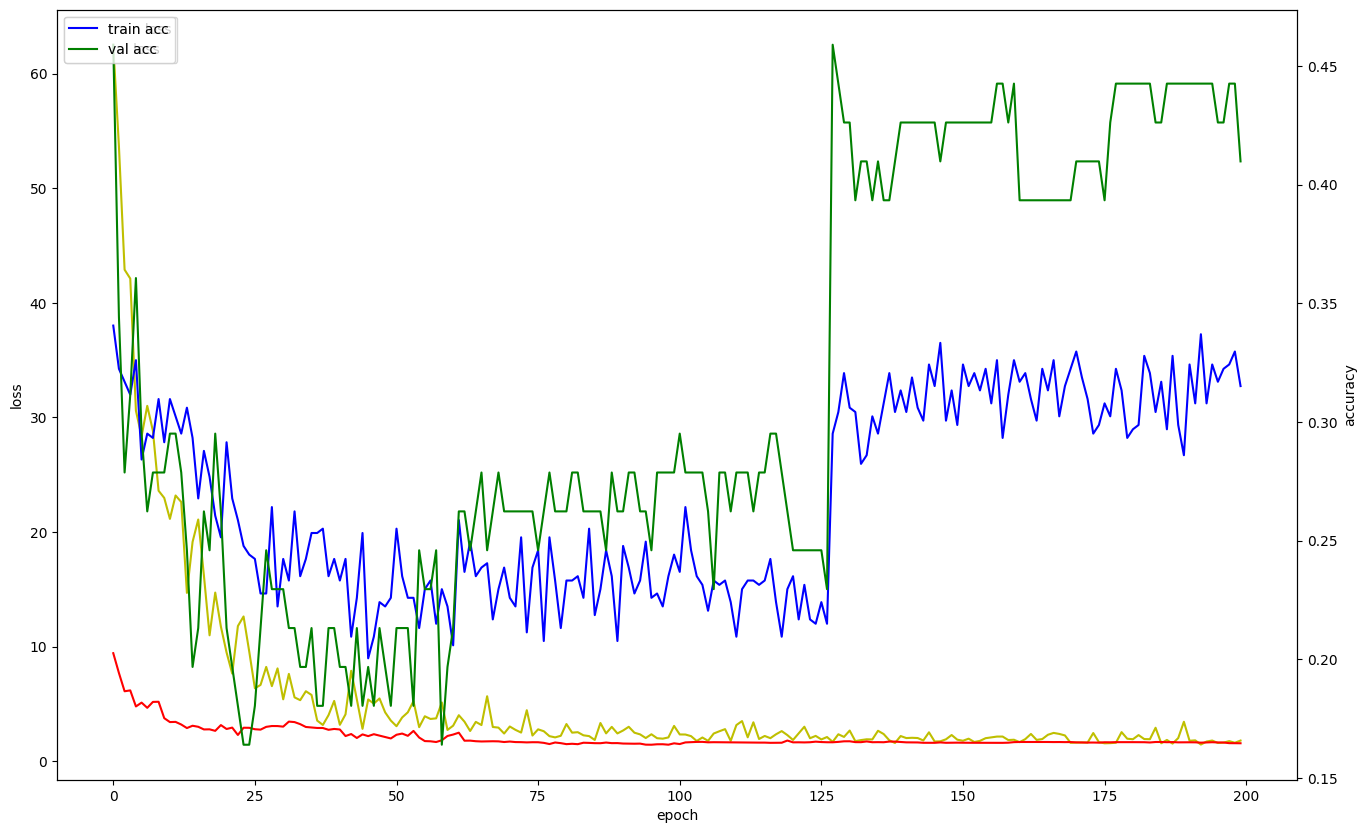

In [13]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [10]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/hand_gesture_classifier.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[[43,  7],
        [ 8,  3]],

       [[30, 14],
        [ 1, 16]],

       [[47,  2],
        [ 7,  5]],

       [[49,  3],
        [ 6,  3]],

       [[47,  2],
        [ 6,  6]]], dtype=int64)

In [11]:
import tensorflow as tf
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('models/hand_gesture_classifier.tflite', 'wb') as f:
    f.write(tflite_model)



INFO:tensorflow:Assets written to: C:\Users\lleague\AppData\Local\Temp\tmpllx85ika\assets
